# Brosa Modes Applied to the Cf-252 $Y(A,TKE)$ sf Yield

In [1]:
import numpy as np
import scipy as sp
import scipy.optimize as opt
import os
from statistics import *
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import sympy as sym
from sympy.interactive import printing
printing.init_printing(use_latex = 'mathjax')
from IPython.display import display, Math, Latex
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from matplotlib.pyplot import cm
import pylab as pl
from scipy.stats import chisquare
%matplotlib inline

In [2]:
### rcParams are the default parameters for matplotlib
import matplotlib as mpl

print ("Matplotbib Version: ", mpl.__version__)

mpl.rcParams['font.size'] = 18
mpl.rcParams['font.family'] = 'Helvetica', 'serif'
#mpl.rcParams['font.color'] = 'darkred'
mpl.rcParams['font.weight'] = 'normal'

mpl.rcParams['axes.labelsize'] = 18.
mpl.rcParams['xtick.labelsize'] = 18.
mpl.rcParams['ytick.labelsize'] = 18.
mpl.rcParams['lines.linewidth'] = 2.

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'normal',
        'size'   : 18,
        }

mpl.rcParams['xtick.major.pad']='10'
mpl.rcParams['ytick.major.pad']='10'

mpl.rcParams['image.cmap'] = 'inferno'

Matplotbib Version:  2.0.2


In [3]:
def rearrange(YATKE):
    return np.transpose(np.asarray(YATKE).reshape(150, 200))

def YATKEplot(YATKE):
    fig, axes = pl.subplots(1, 1, figsize=(15, 10))
    c1 = plt.imshow(YATKE, extent=[51,200, 100,299], origin="lower")
    plt.xlabel('A')
    plt.ylabel('TKE')
    plt.colorbar(fraction=0.03, pad=0.04)
    plt.xlim(80,170)
    plt.ylim(150,225)

In [4]:
def gauss(x,mu,sigma,w):
    return w/sigma/np.sqrt(2*np.pi)*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,w1,mu2,sigma2,w2):
    return gauss(x,mu1,sigma1,w1)+gauss(x,mu2,sigma2,w2)

In [5]:
#get yield data for Cf 252 *************************************************************************************
f=open(os.path.join(os.getcwd(),'yieldsATKE.Cf252.sf.dat3'),"r")
lines=f.readlines()
YATKE_data=[]
for x in lines:
    x = x.split()
    if len(x) != 0:
        YATKE_data.append(x[2])
f.close()

#convert from strings to ints
YATKE_data = list(map(int, YATKE_data))

total = sum(YATKE_data)
#normalize yield data
YATKE_data = np.asarray([float(i)/total for i in YATKE_data])

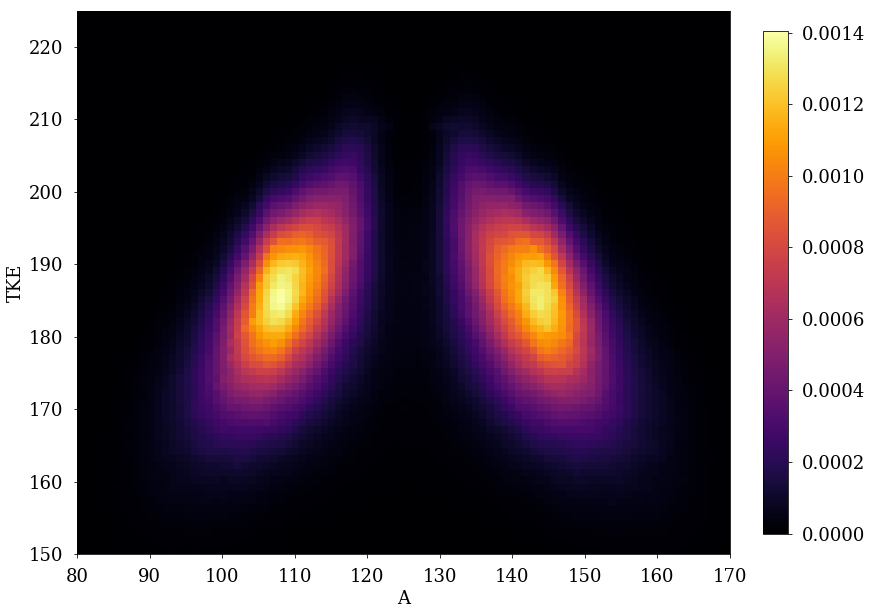

In [6]:
YATKEplot(rearrange(YATKE_data))

In [7]:
# model according to Brosa

def YATKE(tuple_in, h0,h1,h2,h3,h4, dmin0,dmin1,dmin2,dmin3,dmin4, dmax0,dmax1,dmax2,dmax3,dmax4,
         ddec0,ddec1,ddec2,ddec3,ddec4, Abar0,Abar1,Abar2,Abar3,Abar4, sigA0,sigA1,sigA2,sigA3,sigA4):
    
    #unpack the tuple
    A, TKE = tuple_in
    
    # pack the arrays - order of the modes is: SL, S1, S2, S3, SX
    # 30 total parameters, 5 modes x 6 parameters
    h           = np.array([h0,h1,h2,h3,h4])
    dmin        = np.array([dmin0, dmin1, dmin2, dmin3, dmin4])
    dmax        = np.array([dmax0, dmax1, dmax2, dmax3, dmax4]) 
    ddec        = np.array([ddec0, ddec1, ddec2, ddec3, ddec4])
    Abar        = np.array([Abar0, Abar1, Abar2, Abar3, Abar4])
    sigA        = np.array([sigA0, sigA1, sigA2, sigA3, sigA4])
    
    
    # define YATKE
    Y = [] # yield list that will be returned
    
    # sub "cn" refers to 'compound nucleus' - in this case the 252 pre-fission nucleus
    A_cn = 252.
    Z_cn = 98.
    
    e2 = 1.4399643929 # MeV fm
    #see http://www.vanderbilt.edu/AnS/physics/volker/p340a/section_1/1.3_notes_nucl_units.pdf
                        # e^2 = alpha * hbar * c
    # i index over A - turn into columns when rearranged
    for i in range(len(A)):
        # j index over TKE - rows of rearranged data
        for j in range(len(TKE)):
            Yij = 0.
            # k index over modes
            for k in range(len(h)):
                
                T = (Z_cn / A_cn) ** 2 * (A[i] * (A_cn - A[i]) * e2) / TKE[j] - dmin[k] # fm
                
                if (T <= 0.0):
                    Yij = 0.
                else:
                    YTKE = (200/TKE[j])** 2 * h[k] * np.exp(2*(dmax[k]-dmin[k])/ddec[k] - 
                                                       T/ddec[k] - (dmax[k] - dmin[k])**2/T/ddec[k])
                
                    #remember that the sL mode is NOT bimodal
                    if (k != 0):
                    
                        YA = 1/np.sqrt(8*np.pi*sigA[k]**2) * \
                        (np.exp(-(A[i]-Abar[k])**2/(2*sigA[k]**2)) + \
                         np.exp(-(A[i]-A_cn+Abar[k])**2/(2*sigA[k]**2)))
                        
                    else:
                        YA = 1/np.sqrt(2*np.pi*sigA[k]**2) * \
                        np.exp(-(A[i]-Abar[k])**2/(2*sigA[k]**2))

                    Yij += YTKE * YA
                
            Y.append(Yij)
            
    total = sum(Y)
    #normalize yield data
    Y = np.asarray([float(i)/total for i in Y])
    
    return np.asarray(Y)

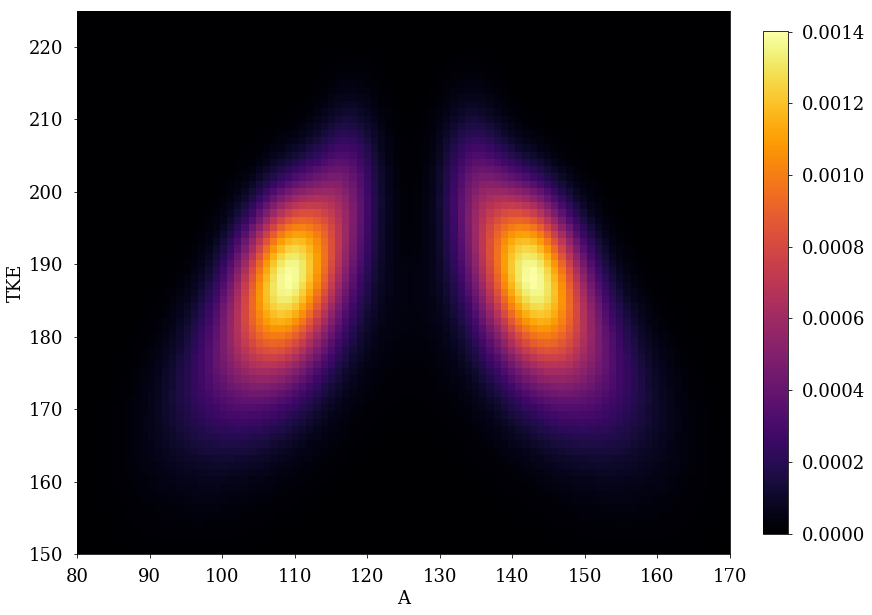

In [8]:
# define A
A = np.linspace(51,200,150)

# define TKE
TKE = np.linspace(100,299,200)

YATKE_brosa = YATKE((A,TKE), 2.02e4, 1.47e5, 8.7e5, 3.15e5, 7.6e3,
                   16.8, 10.9, 13.7, 13.5, 15.0, 
                   18.7, 17.1, 17.9, 18.7, 19.5, 
                   0.521, 0.125, 0.270, 0.317, 0.180,
                   126.9, 134.9, 142.5, 148.5, 178.3, 
                   11.62, 3.16,  4.99,  7.14,  2.25)



YATKEplot(rearrange(YATKE_brosa))

Power_divergenceResult(statistic=0.94525978864558069, pvalue=1.0)


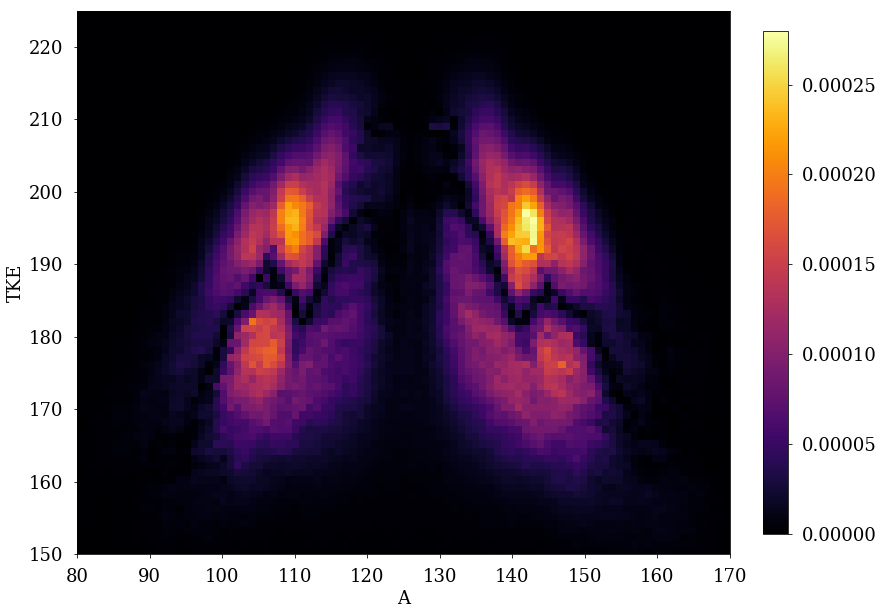

In [9]:
YATKEplot(np.abs(rearrange(YATKE_brosa) - rearrange(YATKE_data)))
chi2 = chisquare(YATKE_brosa[YATKE_data != 0.], YATKE_data[YATKE_data != 0.])
print(chi2)

In [10]:
# mode s2 optimization
hl, h1, h2, h3, hx = 2.02e4, 1.47e5, 8.7e5, 3.15e5, 7.6e3
dminl, dmin1, dmin2, dmin3, dminx = 16.8, 10.9, 13.7, 13.5, 15.0
dmaxl, dmax1, dmax2, dmax3, dmaxx = 18.7, 17.1, 17.9, 18.7, 19.5
ddecl, ddec1, ddec2, ddec3, ddecx = 0.521, 0.125, 0.270, 0.317, 0.180
Abarl, Abar1, Abar2, Abar3, Abarx = 126.9, 134.9, 142.5, 148.5, 178.3
sigAl, sigA1, sigA2, sigA3, sigAx = 11.62, 3.16,  4.99,  7.14,  2.25


s2_guess = (h2, dmin2,  dmax2,  ddec2, Abar2, sigA2)

popts2,pcovs2 = opt.curve_fit(lambda tuple_in, h2, dmin2, dmax2, ddec2, Abar2, sigA2: YATKE(tuple_in, hl,h1,h2,h3,hx, dminl,dmin1,dmin2,dmin3,dminx, dmaxl,dmax1,dmax2,dmax3,dmaxx,
         ddecl,ddec1,ddec2,ddec3,ddecx, Abarl,Abar1,Abar2,Abar3,Abarx, sigAl,sigA1,sigA2,sigA3,sigAx),
                         (A, TKE), YATKE_data, p0=s2_guess)

[  8.91818823e+05   1.48297111e+01   1.80663699e+01   3.92006710e-01
   1.42530737e+02   5.34237196e+00]
Power_divergenceResult(statistic=0.8048255404472402, pvalue=1.0)


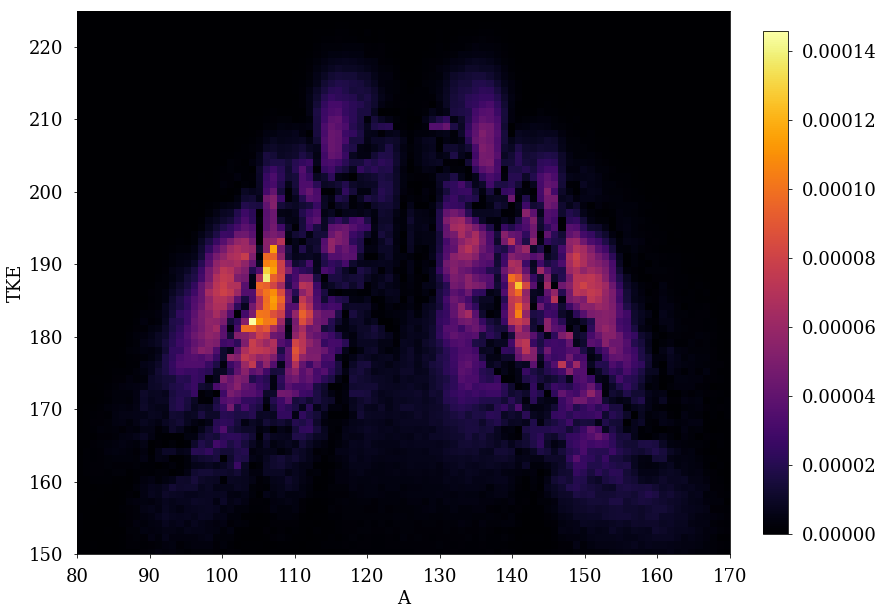

In [11]:
print(popts2)
s2_fitted = YATKE((A, TKE), hl,h1,popts2[0],h3,hx, 
                dminl,dmin1,popts2[1],dmin3,dminx, 
                dmaxl,dmax1,popts2[2],dmax3,dmaxx,
                ddecl,ddec1,popts2[3],ddec3,ddecx, 
                Abarl,Abar1,popts2[4],Abar3,Abarx,
                sigAl,sigA1,popts2[5],sigA3,sigAx)
YATKEplot(np.abs(rearrange(s2_fitted) - rearrange(YATKE_data)))
chi22 = chisquare(s2_fitted[YATKE_data != 0.], YATKE_data[YATKE_data != 0.])
print(chi22)

h2 = popts2[0]
dmin2 = popts2[1]
dmax2 = popts2[2]
ddec2 = popts2[3]
Abar2 = popts2[4]
sigA2 = popts2[5]

In [12]:
# mode s1 optimization

s1_guess = (h1, dmin1,  dmax1,  ddec1, Abar1, sigA1)

popts1,pcovs1 = opt.curve_fit(lambda tuple_in, h1, dmin1, dmax1, ddec1, Abar1, sigA1: YATKE(tuple_in, hl,h1,h2,h3,hx, dminl,dmin1,dmin2,dmin3,dminx, dmaxl,dmax1,dmax2,dmax3,dmaxx,
         ddecl,ddec1,ddec2,ddec3,ddecx, Abarl,Abar1,Abar2,Abar3,Abarx, sigAl,sigA1,sigA2,sigA3,sigAx),
                         (A, TKE), YATKE_data, p0=s1_guess)

[  1.47060880e+05   1.18955254e+01   1.72108148e+01   1.46254809e-01
   1.34723093e+02   3.06790381e+00]
Power_divergenceResult(statistic=0.80122367070865463, pvalue=1.0)


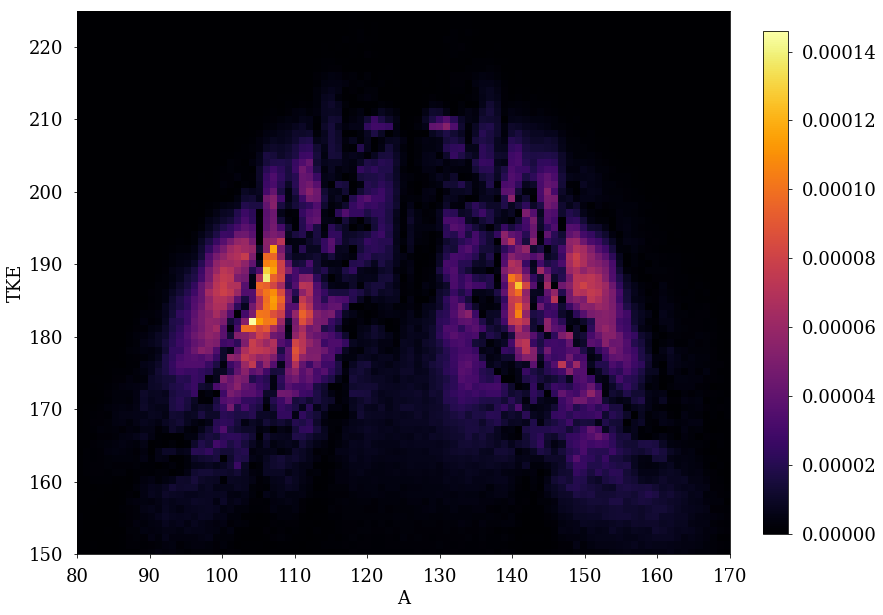

In [13]:
print(popts1)
s1_fitted = YATKE((A, TKE), hl,popts1[0],h2,h3,hx, 
                dminl,popts1[1],dmin2,dmin3,dminx, 
                dmaxl,popts1[2],dmax2,dmax3,dmaxx,
                ddecl,popts1[3],ddec2,ddec3,ddecx,
                Abarl,popts1[4],Abar2,Abar3,Abarx, 
                sigAl,popts1[5],sigA2,sigA3,sigAx)
YATKEplot(np.abs(rearrange(s1_fitted) - rearrange(YATKE_data)))
chi21 = chisquare(s1_fitted[YATKE_data != 0.], YATKE_data[YATKE_data != 0.])
print(chi21)

h1 = popts1[0]
dmin1 = popts1[1]
dmax1 = popts1[2]
ddec1 = popts1[3]
Abar1 = popts1[4]
sigA1 = popts1[5]

In [14]:
# mode s3 optimization

s3_guess = (h3, dmin3,  dmax3,  ddec3, Abar3, sigA3)

popts3,pcovs3 = opt.curve_fit(lambda tuple_in, h3, dmin3, dmax3, ddec3, Abar3, sigA3: YATKE(tuple_in, hl,h1,h2,h3,hx, dminl,dmin1,dmin2,dmin3,dminx, dmaxl,dmax1,dmax2,dmax3,dmaxx,
         ddecl,ddec1,ddec2,ddec3,ddecx, Abarl,Abar1,Abar2,Abar3,Abarx, sigAl,sigA1,sigA2,sigA3,sigAx),
                         (A, TKE), YATKE_data, p0=s3_guess)

[  2.66265064e+05   1.54383042e+01   1.88078416e+01   4.43361576e-01
   1.49220484e+02   6.29174043e+00]
Power_divergenceResult(statistic=0.88101929239455956, pvalue=1.0)


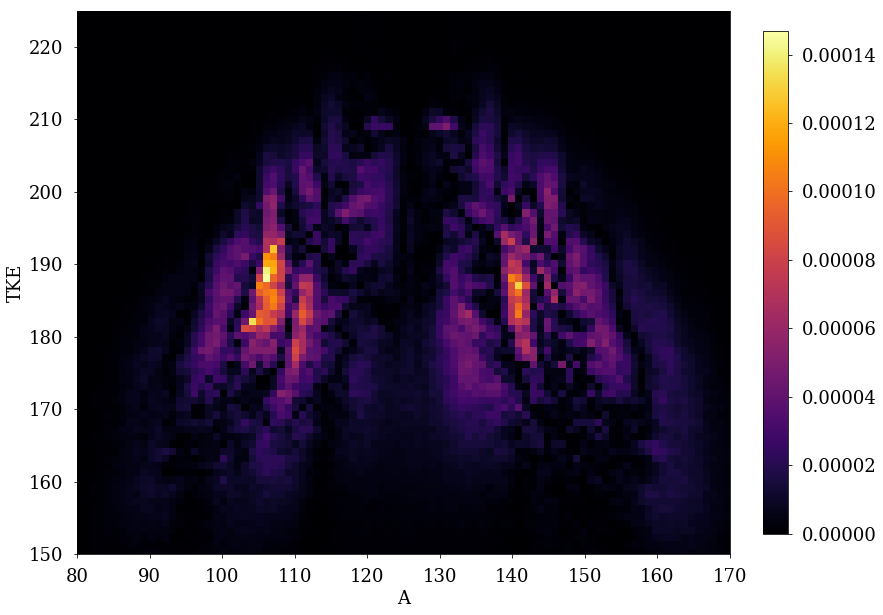

In [15]:
print(popts3)
s3_fitted = YATKE((A, TKE), hl,popts1[0],popts2[0],popts3[0],hx, 
                dminl,popts1[1],popts2[1],popts3[1],dminx, 
                dmaxl,popts1[2],popts2[2],popts3[2],dmaxx,
                ddecl,popts1[3],popts2[3],popts3[3],ddecx, 
                Abarl,popts1[4],popts2[4],popts3[4],Abarx, 
                sigAl,popts1[5],popts2[5],popts3[5],sigAx)
YATKEplot(np.abs(rearrange(s3_fitted) - rearrange(YATKE_data)))
chi23 = chisquare(s3_fitted[YATKE_data != 0.], YATKE_data[YATKE_data != 0.])
print(chi23)
h3 = popts3[0]
dmin3 = popts3[1]
dmax3 = popts3[2]
ddec3 = popts3[3]
Abar3 = popts3[4]
sigA3 = popts3[5]

In [16]:
# mode sx optimization

sx_guess = (hx, dminx,  dmaxx,  ddecx, Abarx, sigAx)

poptsx,pcovsx = opt.curve_fit(lambda tuple_in, hx, dminx, dmaxx, ddecx, Abarx, sigAx: YATKE(tuple_in, hl,h1,h2,h3,hx, dminl,dmin1,dmin2,dmin3,dminx, dmaxl,dmax1,dmax2,dmax3,dmaxx,
         ddecl,ddec1,ddec2,ddec3,ddecx, Abarl,Abar1,Abar2,Abar3,Abarx, sigAl,sigA1,sigA2,sigA3,sigAx),
                         (A, TKE), YATKE_data, p0=sx_guess)

[  1.07704192e+04   1.54999043e+01   1.97336212e+01   4.07130353e-01
   1.26128468e+02   7.49943058e+00]
Power_divergenceResult(statistic=0.011773561479319258, pvalue=1.0)


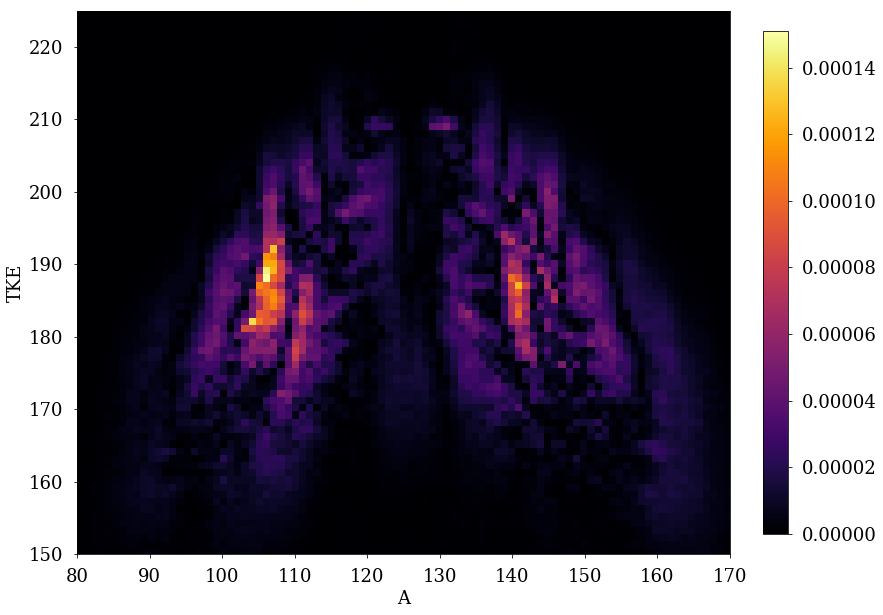

In [17]:
print(poptsx)
sx_fitted = YATKE((A, TKE), hl,popts1[0],popts2[0],popts3[0],poptsx[0], 
                dminl,popts1[1],popts2[1],popts3[1],poptsx[1], 
                dmaxl,popts1[2],popts2[2],popts3[2],poptsx[2],
                ddecl,popts1[3],popts2[3],popts3[3],poptsx[3], 
                Abarl,popts1[4],popts2[4],popts3[4],poptsx[4], 
                sigAl,popts1[5],popts2[5],popts3[5],poptsx[5])
YATKEplot(np.abs(rearrange(sx_fitted) - rearrange(YATKE_data)))
chi2x = chisquare(sx_fitted[YATKE_data != 0.], YATKE_data[YATKE_data != 0.])
print(chi2x)

hx = poptsx[0]
dminx = poptsx[1]
dmaxx = poptsx[2]
ddecx = poptsx[3]
Abarx = poptsx[4]
sigAx = poptsx[5]

In [18]:
# mode sl optimization

sl_guess = (hl, dminl,  dmaxl,  ddecl, Abarl, sigAl)

poptsl,pcovsl = opt.curve_fit(lambda tuple_in, hl, dminl, dmaxl, ddecl, Abarl, sigAl: YATKE(tuple_in, hl,h1,h2,h3,hx, dminl,dmin1,dmin2,dmin3,dminx, dmaxl,dmax1,dmax2,dmax3,dmaxx,
         ddecl,ddec1,ddec2,ddec3,ddecx, Abarl,Abar1,Abar2,Abar3,Abarx, sigAl,sigA1,sigA2,sigA3,sigAx),
                         (A, TKE), YATKE_data, p0=sl_guess)

[  1.19120076e+04   1.66660599e+01   1.87567439e+01   6.15829481e-01
   1.33054791e+02   2.98776532e+00]
Power_divergenceResult(statistic=0.012695117075357774, pvalue=1.0)


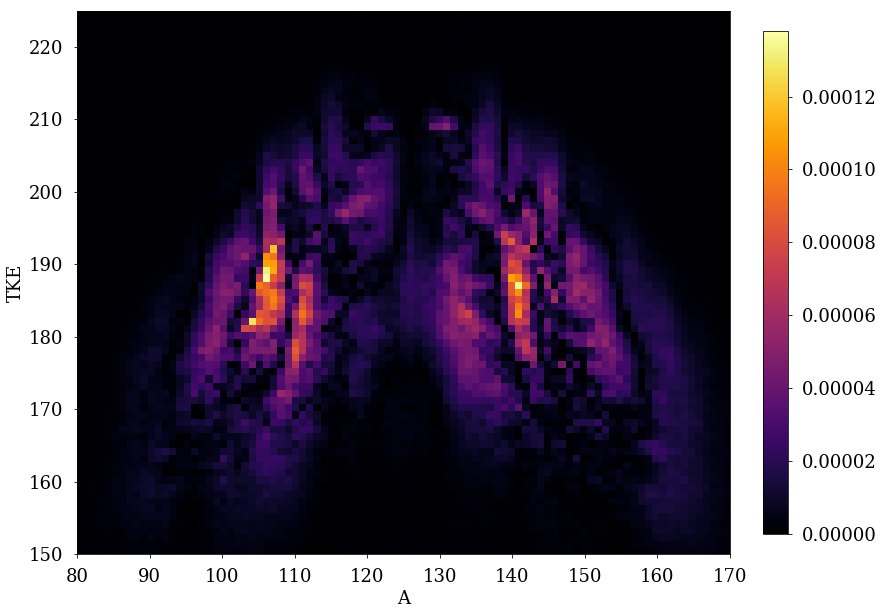

In [19]:
print(poptsl)
sl_fitted = YATKE((A, TKE), poptsl[0],popts1[0],popts2[0],popts3[0],poptsx[0], 
                poptsl[0],popts1[1],popts2[1],popts3[1],poptsx[1], 
                poptsl[0],popts1[2],popts2[2],popts3[2],poptsx[2],
                poptsl[0],popts1[3],popts2[3],popts3[3],poptsx[3], 
                poptsl[0],popts1[4],popts2[4],popts3[4],poptsx[4], 
                poptsl[0],popts1[5],popts2[5],popts3[5],poptsx[5])
YATKEplot(np.abs(rearrange(sl_fitted) - rearrange(YATKE_data)))
chi2l = chisquare(sl_fitted[YATKE_data != 0.], YATKE_data[YATKE_data != 0.])
print(chi2l)

In [20]:
opt_all = [poptsl[0],popts1[0],popts2[0],popts3[0],poptsx[0], 
                poptsl[1],popts1[1],popts2[1],popts3[1],poptsx[1], 
                poptsl[2],popts1[2],popts2[2],popts3[2],poptsx[2],
                poptsl[3],popts1[3],popts2[3],popts3[3],poptsx[3], 
                poptsl[4],popts1[4],popts2[4],popts3[4],poptsx[4], 
                poptsl[5],popts1[5],popts2[5],popts3[5],poptsx[5]]
print(opt_all)

[11912.007573402103, 147060.88047902143, 891818.82300443621, 266265.06428287725, 10770.419221139924, 16.666059865398797, 11.895525352908503, 14.829711089430637, 15.438304192597206, 15.49990434876298, 18.756743907019349, 17.210814831710707, 18.066369860900622, 18.807841582899776, 19.733621216089908, 0.61582948106766033, 0.14625480867175258, 0.39200670988672809, 0.44336157564972356, 0.40713035283592702, 133.05479106068856, 134.72309255918103, 142.53073672625416, 149.22048423088174, 126.12846801028343, 2.9877653228310193, 3.0679038123434297, 5.3423719641312593, 6.2917404255827973, 7.4994305803732475]


In [ ]:
table = 